In [1]:
import h5py
import zipfile 
import cv2 as cv
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Download data

In [4]:
import zipfile

with zipfile.ZipFile('./drive/MyDrive/calo.zip', 'r') as zip_ref:
  zip_ref.extractall('./')

In [5]:
positron_data = h5py.File('./calo/eplus.hdf5', 'r')
pos_group_key = list(positron_data.keys())[3]
positron_second_layer_data = list(positron_data[pos_group_key])

In [6]:
pion_data = h5py.File('./calo/piplus.hdf5', 'r')
pion_group_key = list(pion_data.keys())[3]
pion_second_layer_data = list(pion_data[pos_group_key])

## Observe data

In [7]:
len(positron_second_layer_data)

100000

In [8]:
len(pion_second_layer_data)

100000

In [9]:
positron_second_layer_data[0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 1.78315792, 0.        ,
        0.        ],
       [0.        , 0.82805987, 0.        , 0.3559833 , 0.        ,
        0.        ],
       [0.        , 0.36701843, 0.9486245 , 5.52563904, 4.96058018,
        0.        ],
       [0.        , 0.51099891, 3.75894563, 5.65895993, 2.23624359,
        0.        ],
       [2.43694855, 0.        , 0.54972165, 7.96625306, 1.57433178,
        1.4580423 ],
       [0.        , 1.8229943 , 6.78788657, 1.19695026, 0.        ,
        0.        ],
       [0.49139271, 0.11455069, 4.52358156, 7.246226  , 6.68257787,
        0.        ],
       [0.        , 0.        , 0.        , 0.88070482, 0.        ,
        1.64540192],
       [0.        , 0.        , 0.        , 1.57348787, 0.        ,
        0.        ],
       [0.        , 0

In [10]:
maximums_positron = [0]*len(positron_second_layer_data)
for ind, img in enumerate(positron_second_layer_data):
  maximums_positron[ind] = img.max()

maximums_pion = [0]*len(pion_second_layer_data)
for ind, img in enumerate(pion_second_layer_data):
  maximums_pion[ind] = img.max()

print(max(maximums_positron))
print(max(maximums_pion))

1402.8536887319758
13149.016304413419


(-0.5, 5.5, 11.5, -0.5)

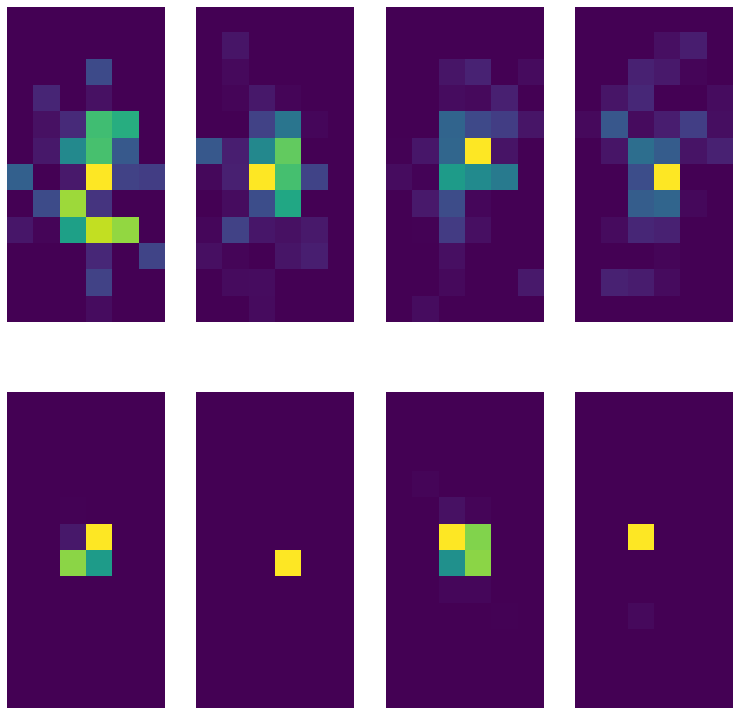

In [11]:
plt.figure(figsize=(13, 13))
plt.tight_layout()
plt.subplot(2,4,1)
plt.imshow(positron_second_layer_data[0])
plt.axis('off') 
plt.subplot(2,4,2)
plt.imshow(positron_second_layer_data[1])
plt.axis('off') 
plt.subplot(2,4,3)
plt.imshow(positron_second_layer_data[2])
plt.axis('off') 
plt.subplot(2,4,4)
plt.imshow(positron_second_layer_data[3])
plt.axis('off') 

plt.subplot(2,4,5)
plt.imshow(pion_second_layer_data[0])
plt.axis('off') 
plt.subplot(2,4,6)
plt.imshow(pion_second_layer_data[1])
plt.axis('off') 
plt.subplot(2,4,7)
plt.imshow(pion_second_layer_data[2])
plt.axis('off') 
plt.subplot(2,4,8)
plt.imshow(pion_second_layer_data[3])
plt.axis('off') 

In [12]:
def outer_sum(img):
  img_masked = img.copy()
  img_masked[5:7, 2:4] = 0

  return np.sum(img_masked)

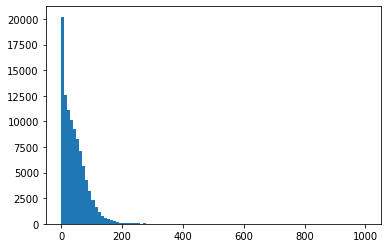

In [13]:
outer_sums_positron = [0]*len(positron_second_layer_data)
for ind, img in enumerate(positron_second_layer_data):
  outer_sums_positron[ind] = outer_sum(img)

plt.hist(outer_sums_positron, range = (0,1000), bins = 100);

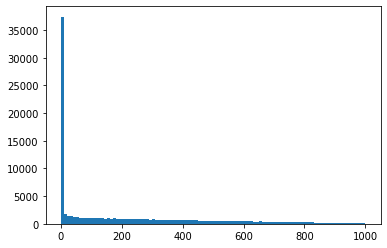

In [14]:
outer_sums_pion = [0]*len(pion_second_layer_data)
for ind, img in enumerate(pion_second_layer_data):
  outer_sums_pion[ind] = outer_sum(img)

plt.hist(outer_sums_pion, range = (0,1000), bins = 100);
ax = plt.gca()

In [15]:
def nonzero_outer_elements(img):
  img_masked = img.copy()
  img_masked[5:7, 2:4] = 0

  return np.sum(img_masked != 0)

Text(0.5, 1.0, 'Positron')

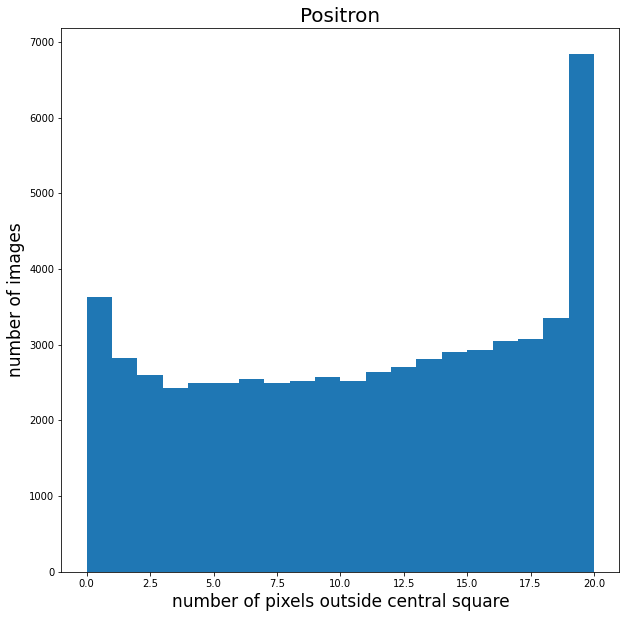

In [23]:
outer_nonzero_positron = [0]*len(positron_second_layer_data)
for ind, img in enumerate(positron_second_layer_data):
  outer_nonzero_positron[ind] = nonzero_outer_elements(img)

plt.figure(figsize = (10,10))
plt.hist(outer_nonzero_positron, range = (0,20), bins = 20);
plt.xlabel("number of pixels outside central square", fontsize = 17)
plt.ylabel("number of images", fontsize = 17)
plt.title("Positron", fontsize = 20)

Text(0.5, 1.0, 'Pion')

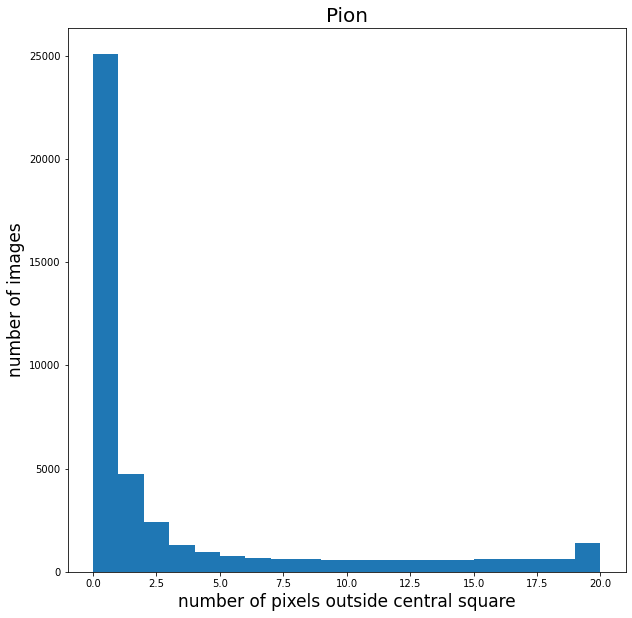

In [25]:
outer_nonzero_pion = [0]*len(pion_second_layer_data)
for ind, img in enumerate(pion_second_layer_data):
  outer_nonzero_pion[ind] = nonzero_outer_elements(img)

plt.figure(figsize = (10,10))
plt.hist(outer_nonzero_pion, range = (0,20), bins = 20);
plt.xlabel("number of pixels outside central square", fontsize=17)
plt.ylabel("number of images", fontsize = 17)
plt.title("Pion", fontsize = 20)

## Converting to [0,255]

In [27]:
def to_img(h5_img):
  img = h5_img
  np.clip(img, 0, 8000, out = img)
  img *= 255
  img /= 8000

  return img

In [28]:
def data_to_imgs(data):
  data_imgs = [None]*len(data)
  for ind, h5_img in enumerate(data):
    data_imgs[ind] = to_img(h5_img)

  return data_imgs

In [29]:
positron_second_layer_imgs = data_to_imgs(positron_second_layer_data)
pion_second_layer_imgs = data_to_imgs(pion_second_layer_data)

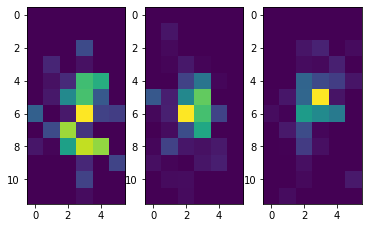

In [30]:
plt.subplot(1,3,1)
plt.imshow(positron_second_layer_imgs[0])
plt.subplot(1,3,2)
plt.imshow(positron_second_layer_imgs[1])
plt.subplot(1,3,3)
plt.imshow(positron_second_layer_imgs[2])

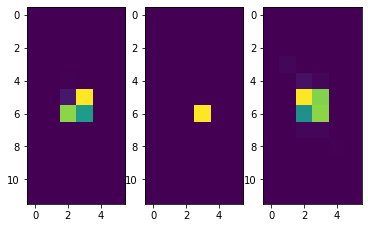

In [31]:
plt.subplot(1,3,1)
plt.imshow(pion_second_layer_imgs[0])
plt.subplot(1,3,2)
plt.imshow(pion_second_layer_imgs[1])
plt.subplot(1,3,3)
plt.imshow(pion_second_layer_imgs[2])

## Train-test split

In [32]:
positron_tags = [0]*len(positron_second_layer_data)
pion_tags = [1]*len(pion_second_layer_data)

train_data, test_data, train_tags, test_tags = train_test_split(positron_second_layer_data + pion_second_layer_data, positron_tags + pion_tags, test_size = 0.2, random_state = 42)

## Evaluation of simple methods

In [33]:
def evaluate(classifier):
  predictions = [0] * len(test_data)
  for ind, img in enumerate(test_data):
    predictions[ind] = classifier(img)
  accuracy = accuracy_score(test_tags, predictions)
  roc_score = roc_auc_score(test_tags, predictions)
  conf_matr = confusion_matrix(test_tags, predictions) / len(test_data)

  return accuracy, roc_score, conf_matr

In [34]:
def evaluate_normalized(classifier):
  test_data_normalized = data_to_imgs(test_data)
  predictions = [0] * len(test_data_normalized)
  for ind, img in enumerate(test_data_normalized):
    predictions[ind] = classifier(img)
  accuracy = accuracy_score(test_tags, predictions)
  roc_score = roc_auc_score(test_tags, predictions)
  conf_matr = confusion_matrix(test_tags, predictions) / len(test_data)

  return accuracy, roc_score, conf_matr

In [35]:
def base_classifier(img):
  return random.choice([0,1])

In [36]:
base_accuracy, base_roc, base_conf_matrix = evaluate(base_classifier)
print("Accuracy:", base_accuracy, "\nRoc:", base_roc, "\nConfusion matrix:\n", base_conf_matrix)

Accuracy: 0.499875 
Roc: 0.49987480748466384 
Confusion matrix:
 [[0.249575 0.25025 ]
 [0.249875 0.2503  ]]


In [37]:
def outer_sum_classifier(img):
  sum = outer_sum(img)

  if sum < 10:
    return 1
  else:
    return 0

In [38]:
outer_sum_accuracy, outer_sum_roc, outer_sum_conf_matrix = evaluate(outer_sum_classifier)
print("Accuracy:", outer_sum_accuracy, "\nRoc:", outer_sum_roc, "\nConfusion matrix:\n", outer_sum_conf_matrix)

Accuracy: 0.3435 
Roc: 0.34338011456406403 
Confusion matrix:
 [[4.25000e-04 4.99400e-01]
 [1.57100e-01 3.43075e-01]]


In [39]:
def outer_nonzero_classifier(img):
  outer_nonzero = nonzero_outer_elements(img)
  if outer_nonzero > 1:
    return 0
  else:
    return 1

In [40]:
outer_nonzero_accuracy, outer_nonzero_roc, outer_nonzero_conf_matrix = evaluate(outer_nonzero_classifier)
print("Accuracy:", outer_nonzero_accuracy, "\nRoc:", outer_nonzero_roc, "\nConfusion matrix:\n", outer_nonzero_conf_matrix)

Accuracy: 0.6171 
Roc: 0.6172107631083185 
Confusion matrix:
 [[0.466675 0.03315 ]
 [0.34975  0.150425]]


## Catboost

In [41]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [42]:
import catboost as ctb

train_size = len(train_data)
vectorized_train_data = np.zeros((train_size, 72))

for ind, img in enumerate(train_data):
  img_vec = img.reshape(1, 72)
  vectorized_train_data[ind, :] = img_vec

cbc = ctb.CatBoostClassifier()
cbc.fit(vectorized_train_data, train_tags, verbose = 1)

Learning rate set to 0.089969
0:	learn: 0.6081042	total: 327ms	remaining: 5m 26s
1:	learn: 0.5396022	total: 520ms	remaining: 4m 19s
2:	learn: 0.4860972	total: 717ms	remaining: 3m 58s
3:	learn: 0.4423636	total: 914ms	remaining: 3m 47s
4:	learn: 0.4083796	total: 1.12s	remaining: 3m 42s
5:	learn: 0.3797328	total: 1.31s	remaining: 3m 37s
6:	learn: 0.3575860	total: 1.52s	remaining: 3m 35s
7:	learn: 0.3386788	total: 1.71s	remaining: 3m 32s
8:	learn: 0.3210371	total: 1.92s	remaining: 3m 31s
9:	learn: 0.3056414	total: 2.16s	remaining: 3m 33s
10:	learn: 0.2910424	total: 2.43s	remaining: 3m 38s
11:	learn: 0.2794950	total: 2.61s	remaining: 3m 35s
12:	learn: 0.2689986	total: 2.81s	remaining: 3m 33s
13:	learn: 0.2600986	total: 3.01s	remaining: 3m 32s
14:	learn: 0.2499800	total: 3.22s	remaining: 3m 31s
15:	learn: 0.2425893	total: 3.49s	remaining: 3m 34s
16:	learn: 0.2354320	total: 3.7s	remaining: 3m 33s
17:	learn: 0.2290997	total: 3.98s	remaining: 3m 37s
18:	learn: 0.2225403	total: 4.21s	remaining: 

In [43]:
test_size = len(test_data)
vectorized_test_data = np.zeros((test_size, 72))

for ind, img in enumerate(test_data):
  img_vec = img.reshape(1, 72)
  vectorized_test_data[ind, :] = img_vec

predictions = cbc.predict(vectorized_test_data)

In [44]:
cb_accuracy = accuracy_score(test_tags, predictions)
cb_roc = roc_auc_score(test_tags, predictions)
cb_conf_matrix = confusion_matrix(test_tags, predictions) / len(test_data)

print("Accuracy:", cb_accuracy, "\nRoc:", cb_roc, "\nConfusion matrix:\n", cb_conf_matrix)

Accuracy: 0.985475 
Roc: 0.9854772994709692 
Confusion matrix:
 [[0.49585  0.003975]
 [0.01055  0.489625]]


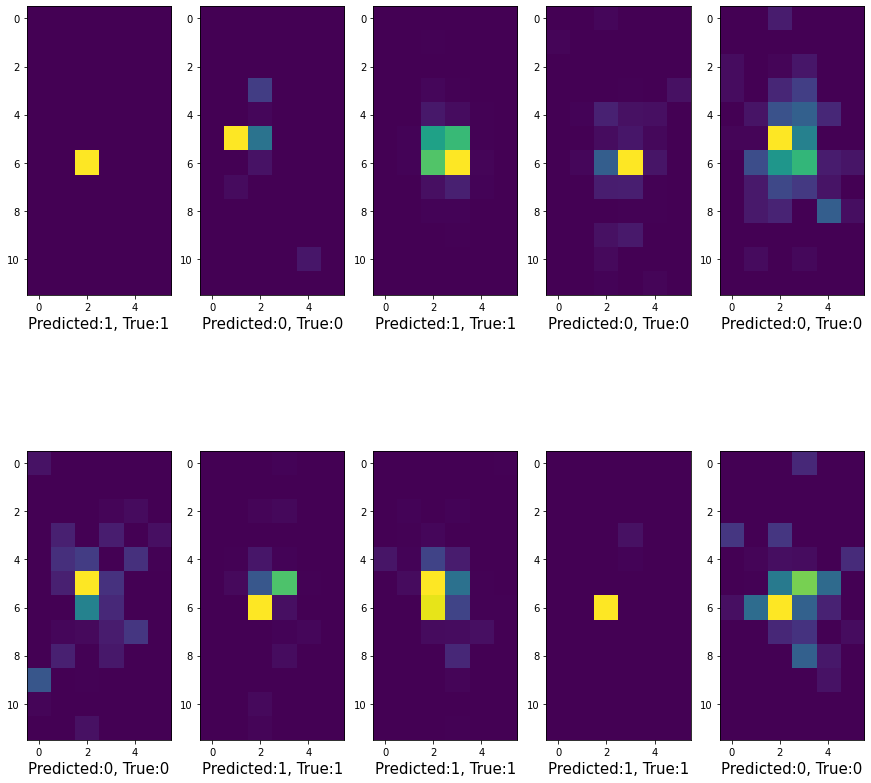

In [54]:
plt.figure(figsize=(15, 15))
plt.tight_layout()

for ind in range(10):
  plt.subplot(2, 5,ind + 1)
  plt.imshow(test_data[ind])
  plt.xlabel('Predicted:{}, True:{}'.format(predictions[ind], test_tags[ind]), fontsize = 15)

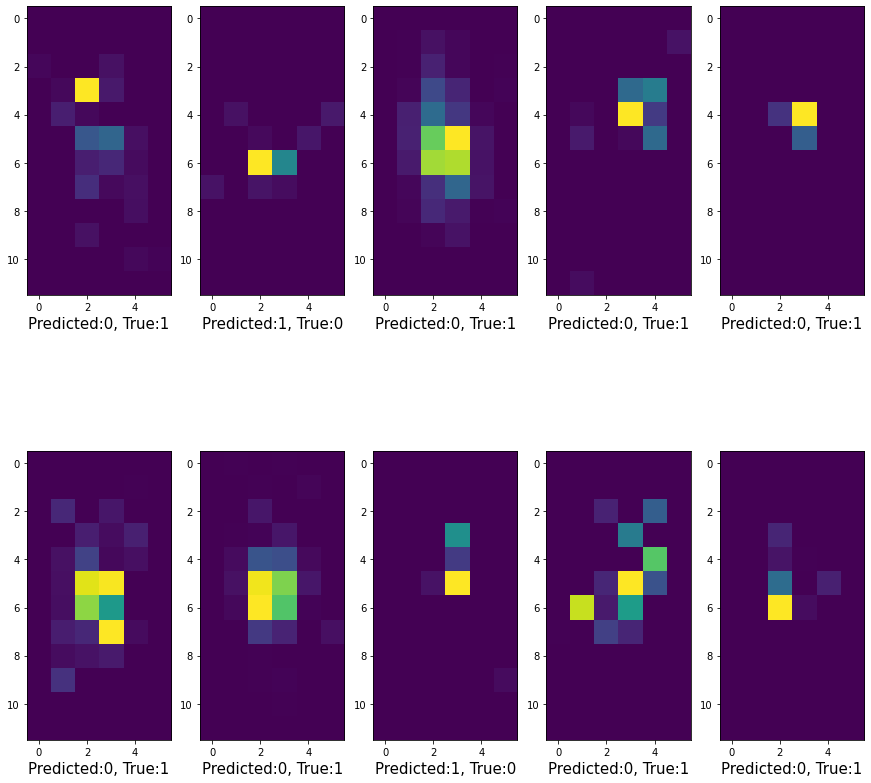

In [59]:
mismatches = 0
max_mismatches = 9
mismatched_imgs = []
predicted = []
true = []

for ind, prediction in enumerate(predictions):
  if prediction != test_tags[ind]:
    mismatched_imgs.append(test_data[ind])
    predicted.append(prediction)
    true.append(test_tags[ind])
    mismatches += 1
    if mismatches > max_mismatches:
      break;

plt.figure(figsize=(15, 15))
plt.tight_layout()
for ind, img in enumerate(mismatched_imgs):
  plt.subplot(2, 5, ind + 1)
  plt.imshow(img)
  plt.xlabel('Predicted:{}, True:{}'.format(predicted[ind], true[ind]), fontsize = 15)

## Template matching

In [39]:
template1 = np.zeros((4,4))
template2 = np.zeros((4,4))
numer_of_imgs = 90

for i in range(numer_of_imgs):
    template1 += positron_second_layer_imgs[i][4:8, 1:5]
template_pos = np.float32(template1 / numer_of_imgs)

for i in range(numer_of_imgs):
    template2 += pion_second_layer_imgs[i][4:8, 1:5]
template_pion = np.float32(template2 / numer_of_imgs)

def template_match_classification(img):
    img = np.float32(img)
    tableHitPos = cv.matchTemplate(template_pos, img, method=cv.TM_CCOEFF_NORMED)
    tableHitPion = cv.matchTemplate(template_pion, img, method=cv.TM_CCOEFF_NORMED)
    (min_valPos, max_valPos, minLocPos, maxLocPos) = cv.minMaxLoc(tableHitPos)
    (min_valPion, max_valPion, minLocPion, maxLocPion) = cv.minMaxLoc(tableHitPion)
    if max_valPos > max_valPion:
        return 1
    else:
        return 0

tm_accuracy, tm_roc, tm_conf_matrix = evaluate_normalized(template_match_classification)
print("Accuracy:", tm_accuracy, "\nRoc:", tm_roc, "\nConfusion matrix:\n", tm_conf_matrix)

Accuracy: 0.531725 
Roc: 0.5316813938809708 
Confusion matrix:
 [[0.203475 0.29635 ]
 [0.171925 0.32825 ]]
